У цьому проекті я побудувала аналітику продажів інтернет-магазину, використовуючи три інструменти: SQL, Python та Tableau.

### Зміст аналізу:
- За допомогою скрипта Python підключитись до бази даних в Google BigQuery;
- На основі таблиць, наявних у базі даних, напиcати запит у Python щоб створити датасет для подальшого аналізу;
- Описовий аналіз датасету;
- Визначення Топ-3 континенти за продажами та кількістю замовлень;
- Визначення Топ-5 країн за продажами та кількістю замовлень;
- Визначення Топ-10 категорій товарів за загальною сумою продажів;
- Обчислення продажів та підрахунок % співідношення у розрізі девайсів;
- Обчислення продажів та підрахунок % співідношення у розрізі каналів трафіку;
- Аналіз поведінки (у плані продажів) користувачів, хто відписався від розсилки та тих, хто досі підписаний;
- Аналіз динаміки продажів за кожну дату (в розрізі девайсів, каналів трафіку, континентів);
- Статистичний аналіз взаємозв’язків (кількість сесій та загальні продажі за кожну дату);
- Статистичний аналіз відмінностей між групами (продажі за кожну дату зареєстрованих та незареєстрованих користувачів);
- Аналітичний дашборд у Tableau Public.

In [2]:
!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# Аутентифікація
auth.authenticate_user()

# Створення клієнта для BigQuery
client = bigquery.Client(project="data-analytics-mate")

# SQL-запит
query = """
WITH session_data AS (
    SELECT
        s.date AS order_date,
        s.ga_session_id,
        sp.continent,
        sp.country,
        sp.device,
        sp.browser,
        sp.mobile_model_name AS device_model_name,
        sp.operating_system,
        sp.language AS browser_language,
        sp.medium AS traffic_source,
        sp.channel AS traffic_channel
    FROM
        `data-analytics-mate.DA.session` s
    LEFT JOIN
        `data-analytics-mate.DA.session_params` sp
    ON
        s.ga_session_id = sp.ga_session_id
),
order_data AS (
    SELECT
        o.ga_session_id,
        p.category AS product_category,
        p.name AS product_name,
        p.price AS product_price,
        p.short_description AS product_short_description
    FROM
        `data-analytics-mate.DA.order` o
    LEFT JOIN
        `data-analytics-mate.DA.product` p
    ON
        o.item_id = p.item_id
),
user_data AS (
    SELECT
        acs.ga_session_id,
        ac.id AS registered_user_id,
        ac.is_verified,
        CASE
            WHEN ac.is_unsubscribed = 0 THEN TRUE
            ELSE FALSE
        END AS is_subscribed_to_newsletter
    FROM
        `data-analytics-mate.DA.account_session` acs
    LEFT JOIN
        `data-analytics-mate.DA.account` ac
    ON
        acs.account_id = ac.id
)
SELECT
    sd.order_date,
    sd.ga_session_id,
    sd.continent,
    sd.country,
    sd.device,
    sd.browser,
    sd.device_model_name,
    sd.operating_system,
    sd.browser_language,
    sd.traffic_source,
    sd.traffic_channel,
    ud.registered_user_id,
    ud.is_verified AS is_email_verified,
    ud.is_subscribed_to_newsletter,
    od.product_category,
    od.product_name,
    od.product_price,
    od.product_short_description
FROM
    session_data sd
LEFT JOIN
    order_data od
ON
    sd.ga_session_id = od.ga_session_id
LEFT JOIN
    user_data ud
ON
    sd.ga_session_id = ud.ga_session_id
"""
# Виконання запиту
query_job = client.query(query)  # Виконання SQL-запиту
results = query_job.result()  # Очікування завершення запиту

# Перетворення результатів на DataFrame
df = results.to_dataframe()

# Виведення результату
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.7/243.7 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.25.0
    Uninstalling google-cloud-bigquery-3.25.0:
      Successfully uninstalled google-cloud-bigquery-3.25.0


,order_date,ga_session_id,continent,country,device,browser,device_model_name,operating_system,browser_language,traffic_source,traffic_channel,registered_user_id,is_email_verified,is_subscribed_to_newsletter,product_category,product_name,product_price,product_short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [4]:
# Інформація про датасет
print("Інформація про датасет:")
df.info()


Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_date                   349545 non-null  dbdate 
 1   ga_session_id                349545 non-null  Int64  
 2   continent                    349545 non-null  object 
 3   country                      349545 non-null  object 
 4   device                       349545 non-null  object 
 5   browser                      349545 non-null  object 
 6   device_model_name            349545 non-null  object 
 7   operating_system             349545 non-null  object 
 8   browser_language             235279 non-null  object 
 9   traffic_source               349545 non-null  object 
 10  traffic_channel              349545 non-null  object 
 11  registered_user_id           27945 non-null   Int64  
 12  is_email_verified            27945

In [3]:
# Короткий опис отриманого датасету
# Описова статистика для числових полів
df_describe = df.describe()

# Виведення результату
print("Описова статистика датасету:")
print(df_describe)


Описова статистика датасету:
           ga_session_id  registered_user_id  is_email_verified  product_price
count           349545.0             27945.0            27945.0   33538.000000
mean   4992250296.631739       659005.065557            0.71698     953.298679
std    2887450949.537772        13216.529465           0.450474    1317.001775
min               1205.0            636133.0                0.0       3.000000
25%         2493646855.0            647576.0                0.0     170.000000
50%         4988476074.0            658952.0                1.0     445.000000
75%         7491286508.0            670414.0                1.0    1195.000000
max         9999997129.0            681962.0                1.0    9585.000000


Висновки:

- Розрив між кількістю сесій і зареєстрованих користувачів:
тільки невелика частина користувачів (27,945 із 349,545) є зареєстрованими. Можливо, варто оптимізувати стратегію реєстрації.
- Верифікація email:
хоча більшість зареєстрованих користувачів підтвердили свої email (72%), залишається значна частина (28%), які цього не зробили. Варто подумати про покращення комунікації чи спрощення процесу верифікації.
- Широкий діапазон цін на товари:
найдешевші продукти коштують лише 3 дол., тоді як найдорожчі — 9,585 дол. Медіана (445) та середнє значення (953.30) свідчать про те, що більшість продуктів мають низьку або середню ціну, але є продукти преміум-класу.
- Сесії: кількість сесій значно перевищує кількість зареєстрованих користувачів, що вказує на те, що багато користувачів заходять на сайт, але не реєструються. Це можливість для покращення конверсії.

In [ ]:
# Визначення колонок типу datetime
datetime_columns = df.select_dtypes(include=['datetime']).columns
num_datetime_columns = len(datetime_columns)

print(f"Кількість колонок типу datetime: {num_datetime_columns}")
print("Колонки типу datetime:")
print(list(datetime_columns))


Кількість колонок типу datetime: 0
Колонки типу datetime:
[]


In [ ]:
# Приведення колонки order_date до типу datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Перевірка типу
print(df.dtypes['order_date'])


datetime64[ns]


In [ ]:
# Перевірка наявності колонок типу datetime
datetime_columns = df.select_dtypes(include=['datetime']).columns
num_datetime_columns = len(datetime_columns)

print(f"Кількість колонок типу datetime: {num_datetime_columns}")
print("Колонки типу datetime:")
print(list(datetime_columns))


Кількість колонок типу datetime: 1
Колонки типу datetime:
['order_date']


In [ ]:
# Підрахунок пропущених значень у кожній колонці
missing_values = df.isnull().sum()

# Виведення колонок з кількістю пропущених значень
print(missing_values)

# Загальна кількість пропущених значень у датасеті
total_missing = missing_values.sum()
print(f"Загальна кількість пропущених значень: {total_missing}")


order_date                          0
ga_session_id                       0
continent                           0
country                             0
device                              0
browser                             0
device_model_name                   0
operating_system                    0
browser_language               114266
traffic_source                      0
traffic_channel                     0
registered_user_id             321600
is_email_verified              321600
is_subscribed_to_newsletter    321600
product_category               316007
product_name                   316007
product_price                  316007
product_short_description      316007
dtype: int64
Загальна кількість пропущених значень: 2343094


Колонки з найбільшою кількістю пропущених значень:

- registered_user_id: 321,600
- is_email_verified: 321,600
- is_subscribed_to_newsletter: 321,600
- product_category: 316,007
- product_name: 316,007
- product_price: 316,007
- product_short_description: 316,007
- browser_language: 114,266

Причини пропущених значень:

registered_user_id, is_email_verified, is_subscribed_to_newsletter:

Ці дані відносяться до зареєстрованих користувачів. Пропуски можуть означати, що сесії належать користувачам, які не зареєстрували обліковий запис.

product_category, product_name, product_price, product_short_description:

Ці дані стосуються замовлень. Пропуски вказують на те, що не всі сесії включають покупку товару. Наприклад, користувачі могли переглядати сторінки, але нічого не купили.

Висновки: Не всі користувачі реєструються, купують товари чи вказують свої дані. Це типово для даних, пов’язаних з веб-аналітикою


In [ ]:
# Фільтруємо дані: лише сесії з покупками
sales_data = df.dropna(subset=['product_price', 'ga_session_id'])

# Агрупування за континентами
continent_sales = sales_data.groupby('continent').agg(
    total_sales=('product_price', 'sum'),
    total_orders=('ga_session_id', 'count')
).sort_values(by='total_sales', ascending=False)

# Топ-3 континенти
top_continents = continent_sales.head(3)

# Агрупування за країнами
country_sales = sales_data.groupby('country').agg(
    total_sales=('product_price', 'sum'),
    total_orders=('ga_session_id', 'count')
).sort_values(by='total_sales', ascending=False)

# Топ-5 країн
top_countries = country_sales.head(5)

# Виведення результатів
print("Топ-3 континенти за продажами та кількістю замовлень:")
print(top_continents)

print("\nТоп-5 країн за продажами та кількістю замовлень:")
print(top_countries)


Топ-3 континенти за продажами та кількістю замовлень:
           total_sales  total_orders
continent                           
Americas    17665280.0         18553
Asia         7601298.3          7950
Europe       5934624.2          6261

Топ-5 країн за продажами та кількістю замовлень:
                total_sales  total_orders
country                                  
United States    13943553.9         14673
India             2809762.0          3029
Canada            2437921.0          2560
United Kingdom     938317.9          1029
France             710692.8           678


In [ ]:
# Фільтруємо дані: лише сесії з покупками та з товарними категоріями
category_sales = sales_data.dropna(subset=['product_category', 'product_price'])

# Агрупування за категоріями товарів
category_sales_summary = category_sales.groupby('product_category').agg(
    total_sales=('product_price', 'sum')
).sort_values(by='total_sales', ascending=False)

# Топ-10 категорій товарів
top_10_categories = category_sales_summary.head(10)

# Виведення результатів
print("Топ-10 категорій товарів за загальною сумою продажів:")
print(top_10_categories)


Топ-10 категорій товарів за загальною сумою продажів:
                                  total_sales
product_category                             
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0


In [ ]:
# Фільтруємо дані: лише сесії з покупками та з товарними категоріями і країнами
country_category_sales = sales_data.dropna(subset=['country', 'product_category', 'product_price'])

# Агрупування за країною і категорією товару
country_category_sales_summary = country_category_sales.groupby(['country', 'product_category']).agg(
    total_sales=('product_price', 'sum')
).reset_index()

# Знаходимо країну з найбільшими продажами
top_country = country_category_sales_summary.groupby('country').agg(
    total_sales_country=('total_sales', 'sum')
).sort_values(by='total_sales_country', ascending=False).head(1).index[0]

# Фільтруємо дані по країні з найбільшими продажами
top_country_sales = country_category_sales_summary[country_category_sales_summary['country'] == top_country]

# Топ-10 категорій товарів в цій країні
top_10_categories_in_country = top_country_sales.sort_values(by='total_sales', ascending=False).head(10)

# Виведення результатів
print(f"Топ-10 категорій товарів у країні {top_country} з найбільшими продажами:")
print(top_10_categories_in_country[['product_category', 'total_sales']])


Топ-10 категорій товарів у країні United States з найбільшими продажами:
                      product_category  total_sales
1022                 Sofas & armchairs    3707144.5
1015                            Chairs    2619773.8
1011                              Beds    2213058.0
1012        Bookcases & shelving units    1567606.9
1013              Cabinets & cupboards     994545.5
1019                 Outdoor furniture     929245.2
1023                    Tables & desks     777865.0
1016  Chests of drawers & drawer units     382388.0
1010                     Bar furniture     330805.0
1017              Children's furniture     207575.0


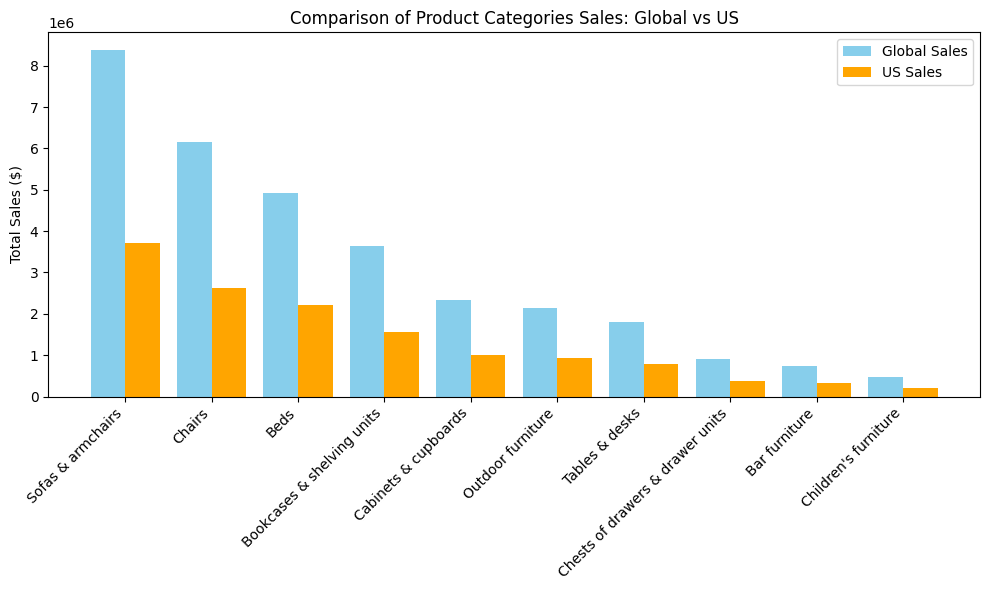

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Підготовка даних: агрегація по категоріях для глобальних продажів та продажів у США

# Спочатку створимо загальний підсумок по всіх категоріях товарів для глобальних продажів
global_sales = df.groupby('product_category')['product_price'].sum().reset_index()  # Групуємо за категорією товару і підсумовуємо ціни
global_sales = global_sales.sort_values(by='product_price', ascending=False).head(10)  # Сортуємо за продажами і вибираємо топ-10

# Тепер виділимо дані для США
us_sales = df[df['country'] == 'United States'].groupby('product_category')['product_price'].sum().reset_index()  # Фільтруємо дані для США
us_sales = us_sales.sort_values(by='product_price', ascending=False).head(10)  # Сортуємо по продажах і вибираємо топ-10

# Візуалізація
fig, ax = plt.subplots(figsize=(10, 6))  # Створюємо фігуру для графіку, задаємо розміри

# Ширина стовпчиків для глобальних та американських продажів
width = 0.4  # Встановлюємо ширину стовпчиків
x = range(len(global_sales))  # Позиції для категорій

# Будуємо стовпчики для глобальних та американських продажів
ax.bar(x, global_sales['product_price'], width, label='Global Sales', color='skyblue')  # Глобальні продажі
ax.bar([p + width for p in x], us_sales['product_price'], width, label='US Sales', color='orange')  # Американські продажі

# Встановлюємо назви категорій на осі X
ax.set_xticks([p + width / 2 for p in x])  # Коригуємо позиції підписів
ax.set_xticklabels(global_sales['product_category'], rotation=45, ha="right")  # Підписи категорій, нахилені на 45 градусів для зручності

# Заголовок та підписи осей
ax.set_ylabel('Total Sales ($)')  # Підпис осі Y (загальні продажі в доларах)
ax.set_title('Comparison of Product Categories Sales: Global vs US')  # Заголовок графіку
ax.legend()  # Додаємо легенду для розрізнення графіків

# Показуємо графік
plt.tight_layout()  # Автоматично коригуємо відстань між елементами графіку
plt.show()  # Виводимо графік на екран



Топ-10 категорій товарів за загальною сумою продажів та топ-10 категорій товарів у країні з найбільшими продажами (United States)  мають однакові категорії. Ці висновки підтверджуються як даними з підрахунків, так і наочно відображаються на графіку, який порівнює продажі по країнах і категоріях

In [ ]:
# Агрегуємо дані по типах девайсів, підсумовуючи продажі
device_sales = sales_data.groupby(['device']).agg(
    total_sales=('product_price', 'sum')
).reset_index()

# Обчислюємо загальні продажі
total_sales_all = device_sales['total_sales'].sum()

# Додаємо стовпець з відсотками
device_sales['sales_percentage'] = (device_sales['total_sales'] / total_sales_all) * 100

# Сортуємо за відсотком продажів
device_sales_sorted = device_sales.sort_values(by='sales_percentage', ascending=False)

# Виведення результатів
device_sales_sorted




,device,total_sales,sales_percentage
0,desktop,18864039.0,59.002245
1,mobile,12384225.8,38.734924
2,tablet,723466.3,2.262831


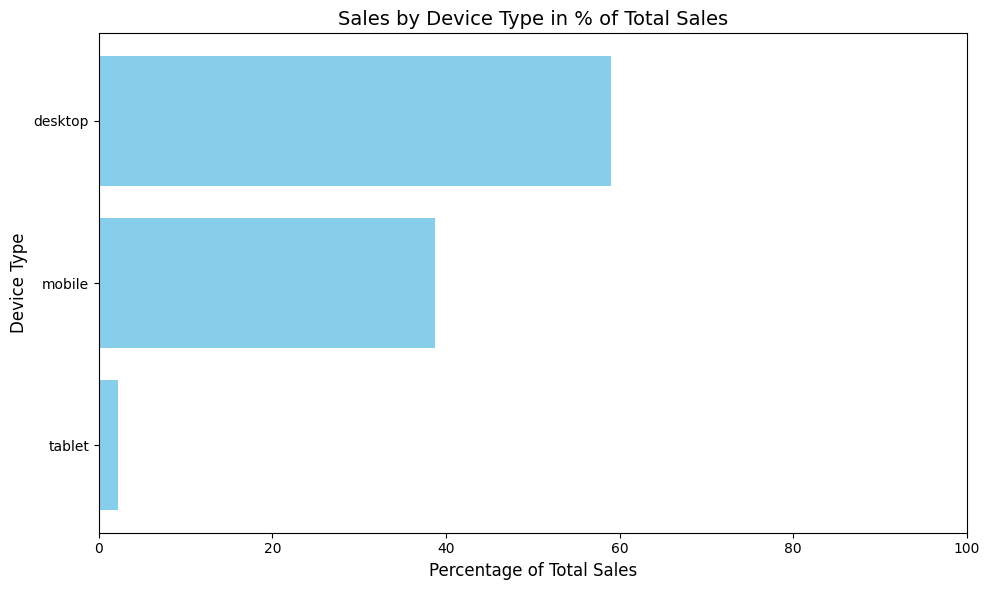

In [ ]:
import matplotlib.pyplot as plt

# Створення графіку
plt.figure(figsize=(10, 6))
plt.barh(device_sales_sorted['device'], device_sales_sorted['sales_percentage'], color='skyblue')

# Додавання підписів та заголовків
plt.xlabel('Percentage of Total Sales', fontsize=12)
plt.ylabel('Device Type', fontsize=12)
plt.title('Sales by Device Type in % of Total Sales', fontsize=14)
plt.gca().invert_yaxis()  # Щоб найвищий відсоток був зверху

# Налаштування меж осі X (100% для максимального значення)
plt.xlim(0, 100)

# Показати графік
plt.tight_layout()
plt.show()





На основі виведених результатів та графіку можна зробити висновки, що серед покупців найбільший попит мають десктопи, які складають 59% від загальних продажів. Це свідчить про те, що більшість покупок відбуваються через настільні комп'ютери.

Мобільні пристрої займають другу позицію з 38.7% продажів, що вказує на високий попит серед користувачів мобільних телефонів для здійснення покупок.

Таблети мають найменшу частку у загальних продажах, складаючи лише 2.26%, що може свідчити про менш активне використання планшетів для покупок.

Цей аналіз дозволяє визначити, що найбільший попит серед покупців мають десктопи та мобільні пристрої. Це важлива інформація для маркетингових стратегій, яка допоможе оптимізувати рекламні кампанії та розробити ефективніші стратегії для кожного типу пристрою.

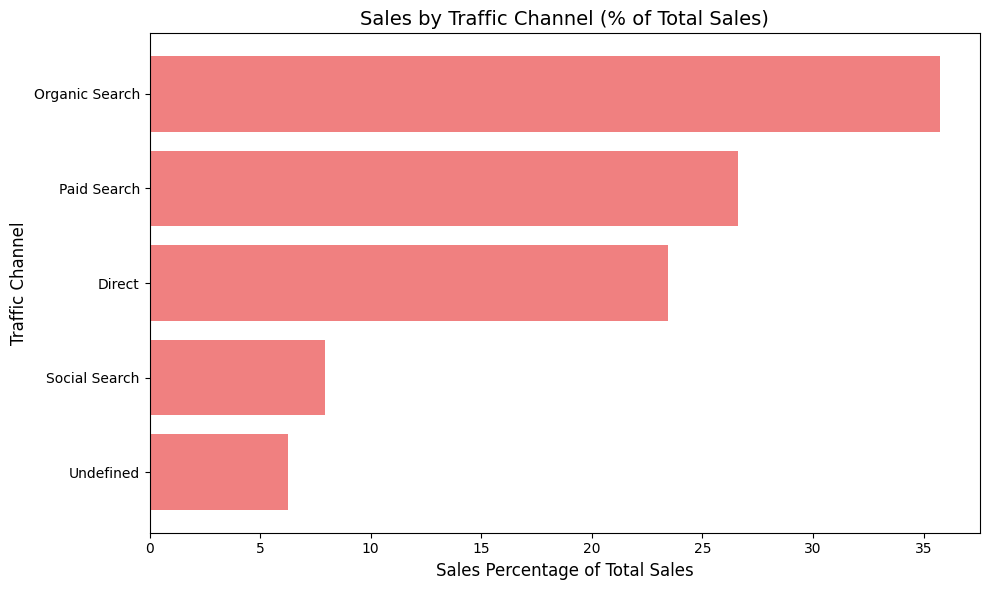

,traffic_channel,total_sales,sales_percentage
1,Organic Search,11433151.6,35.760189
2,Paid Search,8511049.4,26.620546
0,Direct,7494923.4,23.442345
3,Social Search,2532105.7,7.919827
4,Undefined,2000501.0,6.257093


In [ ]:
# Агрумуємо дані за каналами трафіку та підсумовуємо продажі
traffic_channel_sales = sales_data.groupby('traffic_channel').agg(
    total_sales=('product_price', 'sum')
).reset_index()

# Розрахунок відсотка кожного каналу від загальних продажів
total_sales_all_channels = traffic_channel_sales['total_sales'].sum()
traffic_channel_sales['sales_percentage'] = (traffic_channel_sales['total_sales'] / total_sales_all_channels) * 100

# Сортуємо по відсотку від загальних продажів
traffic_channel_sales_sorted = traffic_channel_sales.sort_values(by='sales_percentage', ascending=False)

# Побудова графіку
import matplotlib.pyplot as plt

# Створення графіку
plt.figure(figsize=(10, 6))
plt.barh(traffic_channel_sales_sorted['traffic_channel'], traffic_channel_sales_sorted['sales_percentage'], color='lightcoral')

# Додавання підписів та заголовків
plt.xlabel('Sales Percentage of Total Sales', fontsize=12)
plt.ylabel('Traffic Channel', fontsize=12)
plt.title('Sales by Traffic Channel (% of Total Sales)', fontsize=14)
plt.gca().invert_yaxis()  # Щоб найвищий відсоток був зверху

# Показати графік
plt.tight_layout()
plt.show()

# Виведення результатів
traffic_channel_sales_sorted.head()



Висновки:

Organic Search  є найважливішим каналом для продажів, з часткою 35.76% від загальних продажів. Це свідчить про велику ефективність SEO стратегій і важливість забезпечення високих позицій у пошукових системах.

Paid Search займає друге місце, з часткою 26.62% від загальних продажів. Це вказує на ефективність платних рекламних кампаній і важливість інвестицій у контекстну рекламу для залучення трафіку.

Direct займає 23.44% від продажів, що вказує на наявність лояльних клієнтів, які повертаються до сайту.

Social Search забезпечує 7.92% від загальних продажів, що свідчить про роль соціальних мереж у залученні покупців, хоча цей канал є менш ефективним порівняно з іншими.


Загалом, Organic Search та Paid Search є найбільш ефективними каналами для залучення трафіку і генерації продажів. Це підкреслює важливість як органічних, так і платних стратегій залучення клієнтів. Однак важливо також приділяти увагу менш ефективним каналам, таким як Social Search
 для покращення відстеження і оптимізації маркетингових зусиль.

In [ ]:
# Підрахунок кількості зареєстрованих користувачів, які підтвердили свою електронну адресу
verified_users = df[df['is_email_verified'] == True].shape[0]

# Підрахунок загальної кількості зареєстрованих користувачів
total_registered_users = df['registered_user_id'].nunique()

# Відсоток підтверджених користувачів
percentage_verified = (verified_users / total_registered_users) * 100

print(f"Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: {percentage_verified:.2f}%")



Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: 71.70%


In [ ]:
# Підрахунок кількості зареєстрованих користувачів, які відписались від розсилки
unsubscribed_users = df[df['is_subscribed_to_newsletter'] == False].shape[0]

# Підрахунок загальної кількості зареєстрованих користувачів
total_registered_users = df['registered_user_id'].nunique()

# Відсоток відписаних користувачів
percentage_unsubscribed = (unsubscribed_users / total_registered_users) * 100

print(f"Відсоток зареєстрованих користувачів, які відписалися від розсилки: {percentage_unsubscribed:.2f}%")


Відсоток зареєстрованих користувачів, які відписалися від розсилки: 16.94%


In [ ]:
# Фільтрація користувачів, які відписалися та підписані
subscribed_users = df[df['is_subscribed_to_newsletter'] == True]
unsubscribed_users = df[df['is_subscribed_to_newsletter'] == False]

# Підрахунок загальних продажів для підписаних користувачів
subscribed_sales = subscribed_users['product_price'].sum()

# Підрахунок загальних продажів для відписаних користувачів
unsubscribed_sales = unsubscribed_users['product_price'].sum()

# Порівняння результатів
print(f"Загальні продажі для підписаних користувачів: {subscribed_sales:.2f}")
print(f"Загальні продажі для відписаних користувачів: {unsubscribed_sales:.2f}")

# Підрахунок середніх продажів для підписаних користувачів
average_subscribed_sales = subscribed_users['product_price'].mean()

# Підрахунок середніх продажів для відписаних користувачів
average_unsubscribed_sales = unsubscribed_users['product_price'].mean()

# Порівняння середніх продажів
print(f"Середні продажі для підписаних користувачів: {average_subscribed_sales:.2f}")
print(f"Середні продажі для відписаних користувачів: {average_unsubscribed_sales:.2f}")



Загальні продажі для підписаних користувачів: 2150796.90
Загальні продажі для відписаних користувачів: 431721.60
Середні продажі для підписаних користувачів: 921.51
Середні продажі для відписаних користувачів: 965.82


Згідно з результатами, можна зробити наступні висновки:

Загальні продажі:

Користувачі, які підписані на розсилку, здійснили набагато більше продажів, загалом на суму 2,150,796.90, порівняно з користувачами, які відписалися, де сума продажів склала 431,721.60.
Це означає, що підписка на розсилку сприяє більшим обсягам продажів на рівні компанії. Підписані користувачі вносять більшу частку у загальний дохід.

Середні продажі:

Якщо порівняти середні продажі на одного користувача, то відписані користувачі витрачають в середньому 965.82 на покупку, що більше, ніж у підписаних, у яких середній показник складає 921.51.
Це вказує на те, що хоча підписані користувачі генерують більше продажів загалом, кожен відписаний користувач має схильність робити більші окремі покупки.

Аналіз поведінки користувачів:

Підписка на розсилку допомагає залучити більше покупок у загальному обсязі, однак відписані користувачі здатні робити більші покупки.
Це може стати ключовим моментом для маркетингових стратегій. Можливо, слід дослідити, чому відписані користувачі здійснюють більші покупки і як можна збільшити витрати підписаних користувачів, наприклад, за допомогою персоналізованих пропозицій або спеціальних акцій.
Таким чином, хоча підписка на розсилку сприяє більшим обсягам продажів загалом, стратегічний акцент на залученні відписаних користувачів до регулярних покупок також може бути корисним для підвищення середнього чеку.

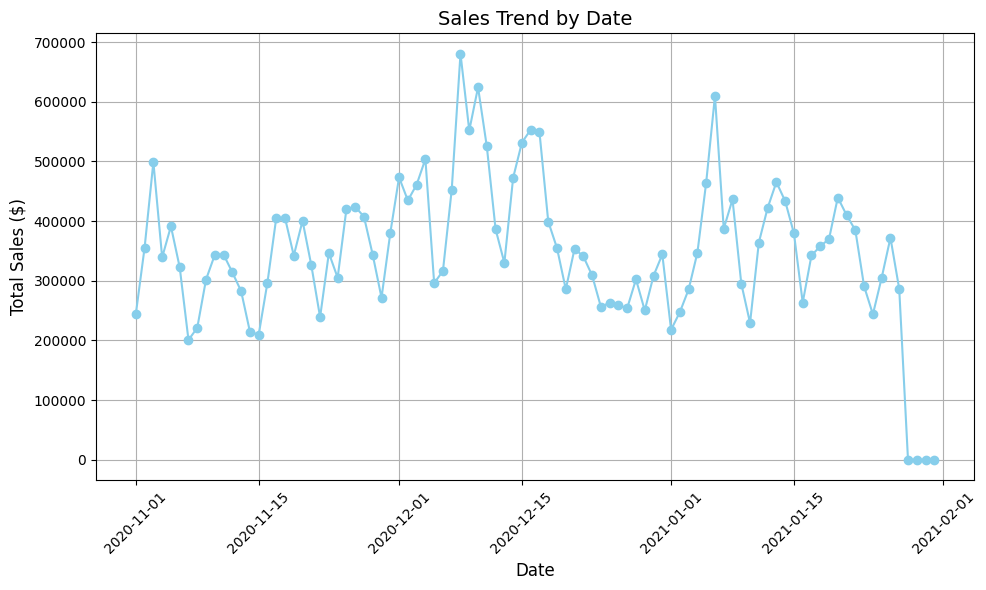

In [ ]:
# Додавання колонки для загальних продажів
df['total_sales'] = df['product_price'] * df['ga_session_id'].map(df.groupby('ga_session_id')['product_name'].count())

# Групуємо дані по датах і сумуємо загальні продажі
sales_by_date = df.groupby(df['order_date'].dt.date)['total_sales'].sum()

# Створюємо графік
plt.figure(figsize=(10, 6))
plt.plot(sales_by_date.index, sales_by_date.values, marker='o', color='skyblue')

# Додавання підписів та заголовків
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.title('Sales Trend by Date', fontsize=14)
plt.xticks(rotation=45)  # Повертаємо підписи осі X для зручності
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()


Загальний графік продажів по датах:

Видно значні коливання у продажах, які можуть бути пов’язані зі святковими періодами, маркетинговими кампаніями чи іншими факторами.
Піки на початку січня та грудня можуть свідчити про святкові покупки, що є типовим для багатьох ринків.

<Figure size 1200x600 with 0 Axes>

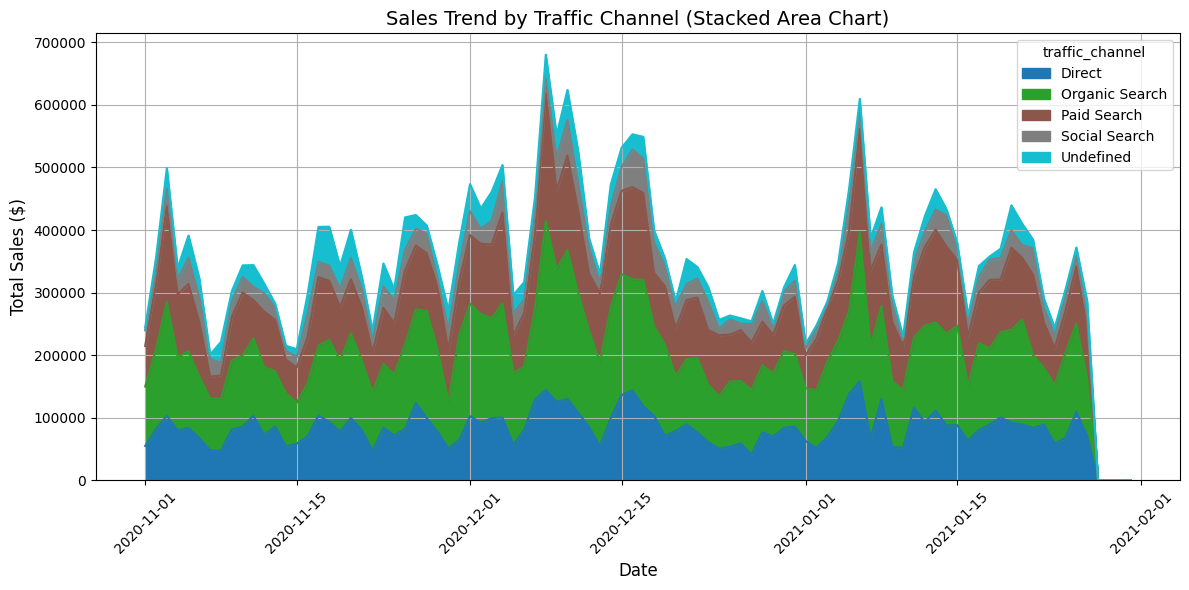

In [ ]:
import matplotlib.pyplot as plt

# Групуємо дані по каналах трафіку та датах і сумуємо загальні продажі
sales_by_traffic_channel_date = df.groupby([df['order_date'].dt.date, 'traffic_channel'])['total_sales'].sum().unstack(fill_value=0)

# Створюємо графік накопичуваної площі
plt.figure(figsize=(12, 6))
sales_by_traffic_channel_date.plot.area(stacked=True, figsize=(12, 6), cmap='tab10')

# Додавання підписів та заголовків
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.title('Sales Trend by Traffic Channel (Stacked Area Chart)', fontsize=14)
plt.xticks(rotation=45)  # Повертаємо підписи осі X для зручності
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()


Висновки по  продажам у розрізі trafic chanel:

Organic Search  та Direct  є найстабільнішими каналами, які постійно приносять високий обсяг продажів.
Paid Search демонструє помітні піки, що можуть свідчити про активні рекламні кампанії або сезонні акції.
Social Search та Undefined приносять значно менший внесок у загальні продажі, і їхній вплив на загальний обсяг незначний.

<Figure size 1200x600 with 0 Axes>

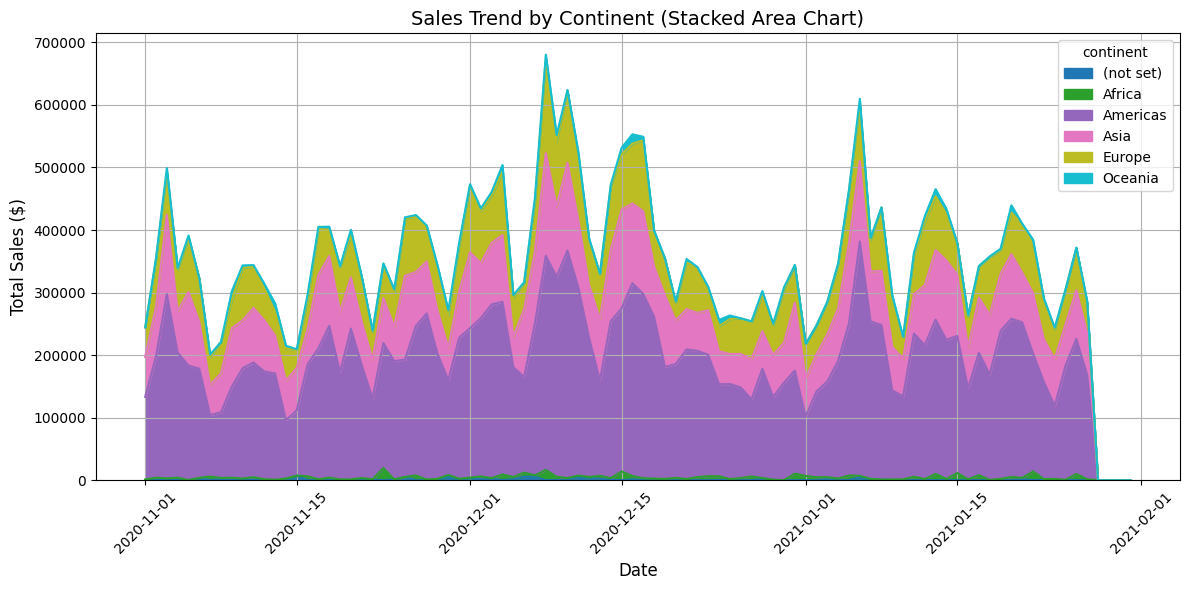

In [ ]:
import matplotlib.pyplot as plt

# Групуємо дані по континентах та датах і сумуємо загальні продажі
sales_by_continent_date = df.groupby([df['order_date'].dt.date, 'continent'])['total_sales'].sum().unstack(fill_value=0)

# Створюємо графік накопичуваної площі
plt.figure(figsize=(12, 6))
sales_by_continent_date.plot.area(stacked=True, figsize=(12, 6), cmap='tab10')

# Додавання підписів та заголовків
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.title('Sales Trend by Continent (Stacked Area Chart)', fontsize=14)
plt.xticks(rotation=45)  # Повертаємо підписи осі X для зручності
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()


Продажі в розрізі континентів:

Америка має стабільно високі продажі та значні піки. Це може свідчити про високий попит під час святкових періодів, таких як Чорна п’ятниця або новорічні свята.
Азія показує стабільні середні продажі з певними зростаннями, що може бути пов’язано з місцевими святами.
Європа має тенденцію до стабільних продажів з  яскраво вираженими піками


<Figure size 1200x600 with 0 Axes>

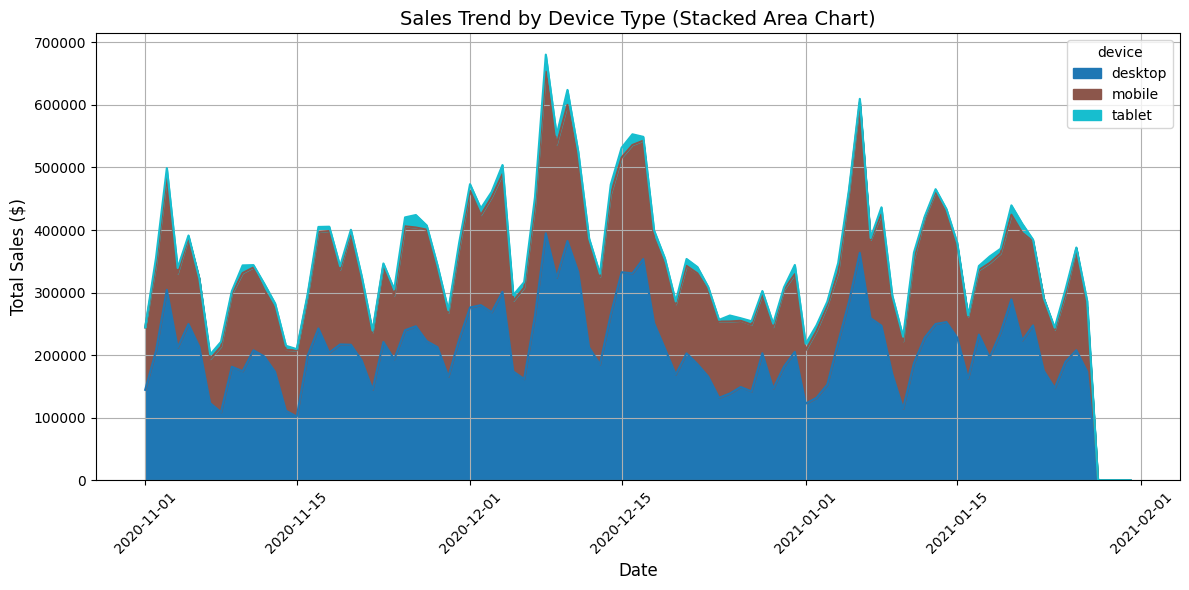

In [ ]:
import matplotlib.pyplot as plt

# Групуємо дані по девайсах та датах і сумуємо загальні продажі
sales_by_device_date = df.groupby([df['order_date'].dt.date, 'device'])['total_sales'].sum().unstack(fill_value=0)

# Створюємо графік
plt.figure(figsize=(12, 6))
sales_by_device_date.plot.area(stacked=True, figsize=(12, 6), cmap='tab10')

# Додавання підписів та заголовків
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.title('Sales Trend by Device Type (Stacked Area Chart)', fontsize=14)
plt.xticks(rotation=45)  # Повертаємо підписи осі X для зручності
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()


Висновки по продажам у розрізі device:

- Desktop :
Продажі через desktop залишаються найвищими протягом усього періоду.
Це свідчить про те, що більшість покупців здійснюють покупки з настільних комп'ютерів. Це може бути пов'язано зі зручністю перегляду складних сторінок (каталогів, технічних характеристик товарів) на великих екранах.
-  Mobile : займає друге місце за обсягом продажів.
На графіку помітно, що мобільні пристрої активно використовуються, але їх внесок значно менший порівняно з desktop. Це може свідчити про те, що багато користувачів переглядають товари на мобільних пристроях, але завершують покупки на desktop.
- Tablet:
 має найменший внесок у загальні продажі. Його роль є майже незначною, і показники залишаються на стабільно низькому рівні.
Це може свідчити про низький рівень популярності планшетів для здійснення покупок, або про те, що користувачі планшетів обирають інші канали.


 Сезонні піки:
Відчутні піки продажів наприкінці листопада (ймовірно, "Чорна п'ятниця") і в грудні (новорічні свята) відображають загальний тренд, проте структура залишає desktop домінуючим.


Рекомендації:
Оптимізація для desktop: Враховуючи домінуючу роль desktop, слід зосередитись на вдосконаленні зручності користування сайтом саме для цього типу пристроїв.
Mobile-friendly підхід: Оскільки мобільні пристрої займають вагоме місце, можна додатково інвестувати в мобільну адаптацію сайту, щоб збільшити конверсії.
Аналіз поведінки tablet-користувачів: Попри низький рівень продажів через планшети, можна розглянути, чи доцільно інвестувати в спеціальні рішення для цієї аудиторії.
Загалом, desktop залишається основним каналом, але підвищення зручності мобільних користувачів може сприяти збільшенню продажів.

In [ ]:
# Створення зведеної таблиці, що показує кількість сесій за каналами трафіку та типами девайсів
pivot_table = df.dropna(subset=['traffic_channel', 'device']).pivot_table(
    index='traffic_channel',
    columns='device',
    values='ga_session_id',
    aggfunc='nunique'
)

# Показати зведену таблицю
pivot_table.head()

device,desktop,mobile,tablet
traffic_channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


In [ ]:
# Фільтруємо дані, вибираючи топ-10 категорій товарів та топ-5 країн
top_10_categories = df.groupby('product_category')['total_sales'].sum().sort_values(ascending=False).head(10).index
top_5_countries = df.groupby('country')['total_sales'].sum().sort_values(ascending=False).head(5).index

# Фільтруємо дані для топ-10 категорій та топ-5 країн
filtered_df = df[df['product_category'].isin(top_10_categories) & df['country'].isin(top_5_countries)]

# Створюємо зведену таблицю з загальними продажами за категоріями товарів та країнами
pivot_table = pd.pivot_table(filtered_df,
                             values='total_sales',
                             index='product_category',
                             columns='country',
                             aggfunc='sum',
                             fill_value=0)

# Виведення зведеної таблиці
pivot_table


country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


In [ ]:
# Створюємо зведену таблицю, де рядки - це країни, а стовпці - підписка на розсилку
country_by_newsletter_subscription = pd.pivot_table(df,
                                                   values='total_sales',  # Значення для агрегації (загальні продажі)
                                                   index='country',  # Розбивка по країнах
                                                   columns='is_subscribed_to_newsletter',  # Розбивка по підписці на розсилку
                                                   aggfunc='sum',  # Агрегуємо суму продажів
                                                   fill_value=0)  # Заповнюємо порожні значення нулями
# Вивести зведену таблицю
print(country_by_newsletter_subscription)

is_subscribed_to_newsletter     False     True 
country                                        
(not set)                       510.0   20038.5
Albania                           0.0      15.0
Algeria                           0.0     325.0
Argentina                       458.0    5758.0
Armenia                           0.0       0.0
...                               ...       ...
United Kingdom                12881.0   52260.5
United States                177507.6  922860.2
Uruguay                           0.0     100.0
Venezuela                         0.0       0.0
Vietnam                         340.0    7379.0

[108 rows x 2 columns]


In [ ]:
# Групуємо дані за датами, підраховуємо кількість сесій і сумуємо загальні продажі
sales_and_sessions_by_date = df.groupby(df['order_date'].dt.date).agg(
    sessions=('ga_session_id', 'nunique'),  # Підрахунок унікальних сесій за дату
    total_sales=('total_sales', 'sum')  # Сума продажів за дату
).reset_index()

# Виведення результату
print(sales_and_sessions_by_date.head())


   order_date  sessions  total_sales
0  2020-11-01      2576     244292.5
1  2020-11-02      3599     355506.8
2  2020-11-03      5173     498979.6
3  2020-11-04      4184     339187.1
4  2020-11-05      3743     391276.6


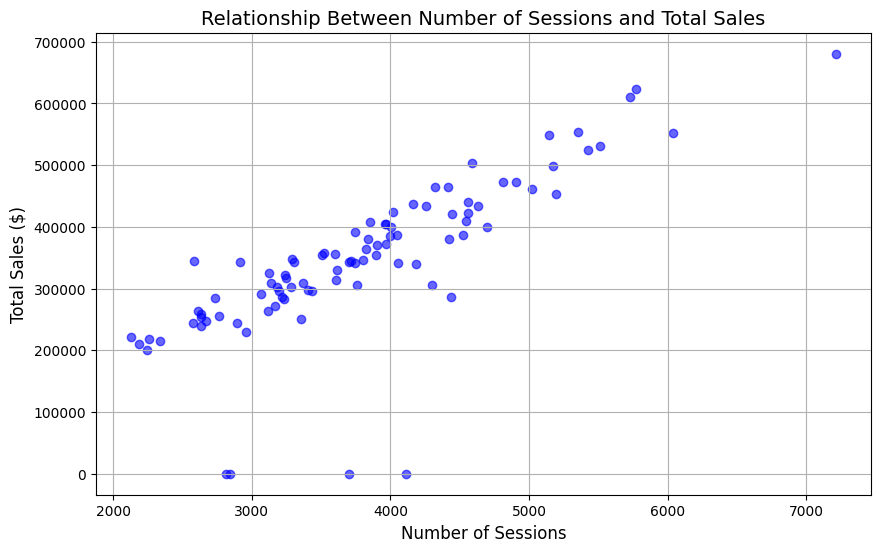

In [ ]:
import matplotlib.pyplot as plt

# Створюємо графік
plt.figure(figsize=(10, 6))

# Точковий графік для кількості сесій і загальних продажів
plt.scatter(sales_and_sessions_by_date['sessions'],
            sales_and_sessions_by_date['total_sales'],
            color='blue', alpha=0.6)

# Додавання підписів та заголовків
plt.xlabel('Number of Sessions', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.title('Relationship Between Number of Sessions and Total Sales', fontsize=14)

# Показати графік
plt.grid(True)
plt.show()


In [ ]:
# Обчислюємо коефіцієнт кореляції Пірсона між кількістю сесій і загальними продажами
correlation = sales_and_sessions_by_date['sessions'].corr(sales_and_sessions_by_date['total_sales'])

# Виводимо коефіцієнт кореляції
print(f'Кореляція між кількістю сесій та загальними продажами: {correlation:.4f}')


Кореляція між кількістю сесій та загальними продажами: 0.7911


In [ ]:
from scipy.stats import pearsonr

# Обчислюємо коефіцієнт кореляції та p-значення
corr_coefficient, p_value = pearsonr(sales_and_sessions_by_date['sessions'],
                                     sales_and_sessions_by_date['total_sales'])

# Виведення результатів
print(f"Коефіцієнт кореляції: {corr_coefficient:.4f}")
print(f"p-значення: {p_value:.4f}")


Коефіцієнт кореляції: 0.7911
p-значення: 0.0000


Аналіз результатів:

Кореляція між кількістю сесій та загальними продажами: Коефіцієнт кореляції між кількістю сесій і загальними продажами становить 0.7911, що вказує на сильний позитивний лінійний зв'язок між цими двома змінними. Це означає, що зростання кількості сесій може бути пов'язане з підвищенням загальних продажів.

Статистична значущість: Значення p-значення становить 0.0000, що є значно меншим за рівень значущості 0.05. Це підтверджує, що кореляція є статистично значущою, і взаємозв'язок між кількістю сесій і загальними продажами не є випадковим.

Висновки:
Є сильний позитивний лінійний зв'язок між кількістю сесій та загальними продажами. Це означає, що збільшення кількості сесій (відвідувачів на сайті) зазвичай призводить до зростання загальних продажів. Це можно бачити і на графіку.

Статистична значущість цього зв'язку вказує на важливість цих двох показників для розуміння ефективності маркетингових кампаній або інших заходів, що стимулюють відвідуваність сайту.
Це дає можливість вивчати та оптимізувати маркетингові стратегії для збільшення трафіку та, відповідно, продажів

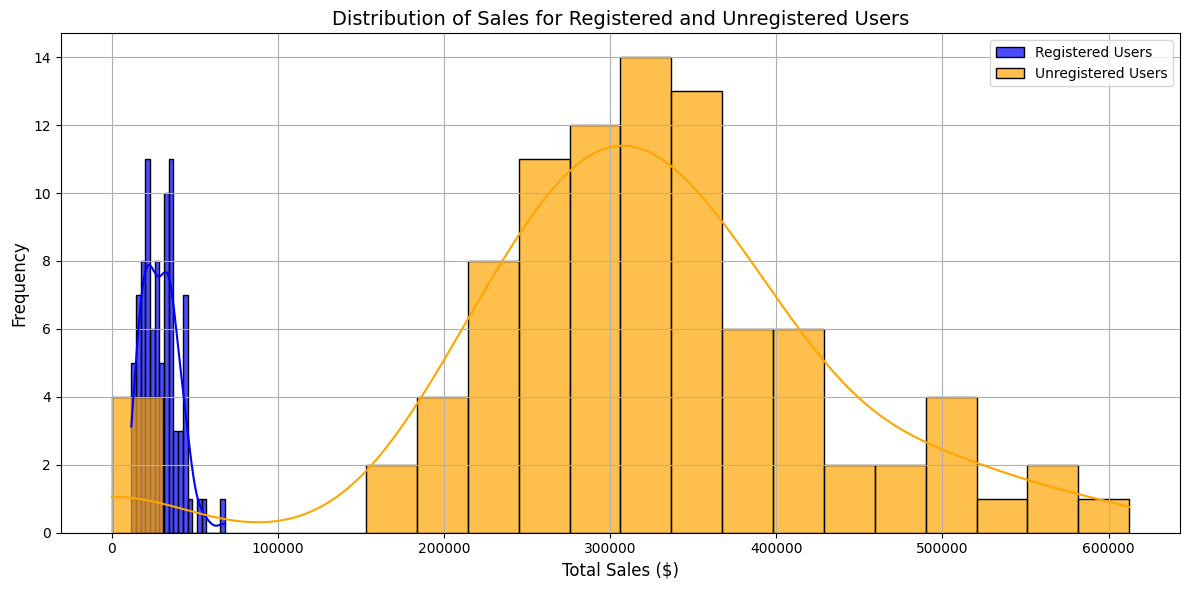

Shapiro-Wilk Test for Registered Users: p-value = 0.0073
Shapiro-Wilk Test for Unregistered Users: p-value = 0.0012

Mann-Whitney U-test Results:
Test Statistic = 352.0000, p-value = 0.0000
Статистично значущі відмінності між групами (відхиляємо нульову гіпотезу).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Групуємо дані по зареєстрованих та незареєстрованих користувачах
registered_sales = df[df['registered_user_id'].notnull()].groupby(df['order_date'].dt.date)['total_sales'].sum()
unregistered_sales = df[df['registered_user_id'].isnull()].groupby(df['order_date'].dt.date)['total_sales'].sum()

# Створюємо вибірки
registered_sales_values = registered_sales.values
unregistered_sales_values = unregistered_sales.values

# Візуалізуємо розподіл продажів
plt.figure(figsize=(12, 6))
sns.histplot(registered_sales_values, bins=20, kde=True, color='blue', label='Registered Users', alpha=0.7)
sns.histplot(unregistered_sales_values, bins=20, kde=True, color='orange', label='Unregistered Users', alpha=0.7)
plt.title('Distribution of Sales for Registered and Unregistered Users', fontsize=14)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Перевіряємо нормальність розподілу
stat_registered, p_registered = shapiro(registered_sales_values)
stat_unregistered, p_unregistered = shapiro(unregistered_sales_values)

print(f"Shapiro-Wilk Test for Registered Users: p-value = {p_registered:.4f}")
print(f"Shapiro-Wilk Test for Unregistered Users: p-value = {p_unregistered:.4f}")

# Вибираємо статистичний тест
if p_registered > 0.05 and p_unregistered > 0.05:
    # Обидва розподіли нормальні - використовуємо t-test
    stat, p_value = ttest_ind(registered_sales_values, unregistered_sales_values, equal_var=False)
    test_name = "T-test"
else:
    # Дані не відповідають нормальному розподілу - використовуємо тест Манна-Уітні
    stat, p_value = mannwhitneyu(registered_sales_values, unregistered_sales_values, alternative='two-sided')
    test_name = "Mann-Whitney U-test"

print(f"\n{test_name} Results:")
print(f"Test Statistic = {stat:.4f}, p-value = {p_value:.4f}")

# Висновок
if p_value < 0.05:
    print("Статистично значущі відмінності між групами (відхиляємо нульову гіпотезу).")
else:
    print("Немає статистично значущих відмінностей між групами (приймаємо нульову гіпотезу).")



Результати вказують на наступне:

Розподіл даних (Shapiro-Wilk Test):

Для зареєстрованих користувачів p-value = 0.0073.
Для незареєстрованих користувачів p-value = 0.0012.
В обох випадках p-значення < 0.05, тому ми відхиляємо нульову гіпотезу, що дані нормально розподілені. Отже, обидві вибірки мають ненормальний розподіл.
Відмінності між групами (Mann-Whitney U-test):

Тестова статистика = 352.0000.
p-value = 0.0000.
Значення p-значення < 0.05 означає, що існують статистично значущі відмінності між групами. Це дозволяє відхилити нульову гіпотезу про відсутність відмінностей між продажами зареєстрованих і незареєстрованих користувачів.

Висновки:
Між зареєстрованими та незареєстрованими користувачами є значущі відмінності в продажах.
Зареєстровані користувачі, ймовірно, демонструють іншу поведінку в плані покупок, наприклад, роблять більше покупок або на більші суми.
Це свідчить про те, що реєстрація може мати позитивний вплив на рівень продажів.

Посиляння на [дашборд](https://public.tableau.com/views/OnlineStoreSalesAnalytics/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link
)

Загальні висновки та бізнес-рекомендації:

1. Найпопулярніші категорії товарів, лідери продажів по країнам:

Сполучені Штати лідирують за обсягом продажів, генерують найбільший дохід. Це свідчить про високу купівельну спроможність на цьому ринку.

Найпопулярніші категорії товарів — меблі (дивани, стільці, ліжка). Ці категорії залишаються основним джерелом доходу.

Рекомендація:
Розробити спеціальні маркетингові кампанії для США та інших провідних країн (Індія, Канада).
Зосередитися на просуванні популярних категорій, таких як "Sofas & armchairs" та "Chairs", наприклад, шляхом акцій чи комбо-пропозицій.

2. Розподіл продажів по пристроях:

Desktop генерує 59% продажів, що вказує на його важливість для покупців.
Мобільні пристрої також є важливими (38.7% продажів), що підкреслює необхідність зручного мобільного інтерфейсу.

Рекомендація:
оптимізувати вебсайт для desktop-користувачів для щє більших продажів (швидкість завантаження, зручний дизайн).
Інвестувати у mobile-friendly дизайн, щоб покращити конверсії серед користувачів смартфонів.
Використовувати таргетовані кампанії для залучення мобільної аудиторії.

3. Канали залучення трафіку:

Organic Search та Paid Search генерують найбільші обсяги продажів.
Direct вказує на наявність лояльних клієнтів, але Social Search потребує покращення.

Рекомендація:
збільшити інвестиції в SEO для підтримки високих органічних позицій.
Оптимізувати рекламні кампанії для Paid Search.
Розширити присутність у соціальних мережах, створюючи інтерактивний контент для залучення нових клієнтів.
4. Поведінка зареєстрованих та незареєстрованих користувачів:

Зареєстровані користувачі генерують більше продажів у загальному обсязі, але незареєстровані витрачають більше на одну покупку.

Рекомендація:
активно мотивувати клієнтів реєструватися через спеціальні бонуси (наприклад, знижки для нових користувачів).
Дослідити поведінку незареєстрованих користувачів, щоб стимулювати їх до регулярних покупок.
5. Динаміка продажів:

Піки продажів наприкінці року (Чорна п’ятниця, новорічні свята) свідчать про сезонний характер покупок.

Рекомендація:
 заздалегідь готувати сезонні маркетингові кампанії з акцентом на популярні товари.
Аналізувати поведінку користувачів у періоди спаду для розробки акцій, що стимулюють продажі.
6. Кореляція між сесіями та продажами:

Сильний зв'язок між кількістю сесій та обсягом продажів підкреслює важливість трафіку.

Рекомендація:
інвестувати в кампанії, що збільшують трафік (наприклад, контент-маркетинг, ремаркетинг).
Постійно аналізувати ефективність джерел трафіку для їх оптимізації.


###Стратегічні дії:
Зосередитися на покращенні клієнтського досвіду через ключові пристрої (desktop та mobile).
Розробити персоналізовані програми лояльності для залучення як підписаних, так і відписаних клієнтів.
Використовувати аналітику для ідентифікації трендів та пікових періодів для оптимізації запасів і рекламних витрат.